In [1]:
%load_ext autoreload
%autoreload 2
notebook_fixed_dir = False

In [2]:
# this cell can only be called once
import os
if not notebook_fixed_dir:
    os.chdir('..')
    notebook_fixed_dir = True
print(os.getcwd())

/home/svcl-oowl/brandon/research/sil_consistent_at_inference


In [5]:
import pprint
import glob
from pathlib import Path
import pickle
import random

import torch
from PIL import Image
import numpy as np
from pytorch3d.renderer import look_at_view_transform
import matplotlib.pyplot as plt
import trimesh

import postprocess_dataset
from utils import utils
from utils import visualization_tools
from utils.eval_utils import eval_metrics
#from evaluation import compute_iou_2d, compute_iou_2d_given_pose, compute_iou_3d, compute_chamfer_L1

In [9]:
def eval_metrics(input_img, rec_mesh, rec_mesh_torch, gt_mesh, gt_mesh_torch, device, metrics_to_eval=["2d_iou", "3d_iou", "3d_iou_norm", "chamfer_L1", "chamfer_L1_norm"],
                 pred_azim=None, pred_elev=None, pred_dist=None):
    
    all_metrics_list = ["2d_iou", "3d_iou", "3d_iou_norm", "chamfer_L1", "chamfer_L1_norm"]
    for metric in metrics_to_eval:
        if metric not in all_metrics_list:
            raise ValueError("Metric {} is unknown.".format(metric))
    
    metrics_dict = {metric:0 for metric in all_metrics_list}
    if "2d_iou" in metrics_to_eval:
        # TODO: not sure if using the original pred pose for the processed iou is legitimate
        if pred_azim is not None and pred_elev is not None and pred_dist is not None:
            metrics_dict["2d_iou"] = compute_iou_2d_given_pose(rec_mesh_torch, input_img, device, pred_azim, pred_elev, pred_dist)
        else:
            metrics_dict["2d_iou"] = compute_iou_2d(rec_mesh_torch, input_img, device)
    if "3d_iou" in metrics_to_eval:
        metrics_dict["3d_iou"] = compute_iou_3d(rec_mesh, rec_mesh_torch, gt_mesh, gt_mesh_torch)
    if "3d_iou_norm" in metrics_to_eval:
        metrics_dict["3d_iou_norm"] = compute_iou_3d(rec_mesh, rec_mesh_torch, gt_mesh, gt_mesh_torch, full_unit_normalize=True)
    if "chamfer_L1" in metrics_to_eval:
        metrics_dict["chamfer_L1"] = compute_chamfer_L1(rec_mesh, rec_mesh_torch, gt_mesh, gt_mesh_torch)
    if "chamfer_L1_norm":
        metrics_dict["chamfer_L1_norm"] = compute_chamfer_L1(rec_mesh, rec_mesh_torch, gt_mesh, gt_mesh_torch, full_unit_normalize=True)
        
    return metrics_dict

In [12]:
# displays meshes at the predicted pose
def show_meshes(input_dir_img, input_dir_mesh, refined_models_dir, gt_shapes_dict, device, only_show_instances=None, num_novel_view=3,
                metrics_to_eval=["2d_iou_input", "2d_iou_multi", "3d_iou","chamfer_L1"], use_gt_poses=True):
    
    if use_gt_poses:
        # loading gt poses
        pred_poses_dict = pickle.load(open(os.path.join(input_dir_img, "renders_camera_params.pt"), "rb"))
        pred_poses_dict = {instance:pred_poses_dict[instance] for instance in pred_poses_dict}
    else:
        # combining all cached predicted poses
        pred_poses_dict = {}
        pred_pose_paths = list(Path(refined_models_dir).rglob('pred_poses.p'))
        for pred_pose_path in pred_pose_paths:
            curr_cache = pickle.load(open(pred_pose_path, "rb"))
            pred_poses_dict = {**pred_poses_dict, **curr_cache}
    
    # getting paths of all processed meshes, keyed by instance name
    processed_paths = list(Path(refined_models_dir).rglob('*.obj'))
    processed_paths_dict = {}
    for path in processed_paths:
        instance_name = str(path).split('/')[-1][:-4]
        if instance_name not in processed_paths_dict:
            processed_paths_dict[instance_name] = [path]
        else:
            processed_paths_dict[instance_name].append(path)
    
    for instance_name in processed_paths_dict:
        if only_show_instances is None or instance_name in only_show_instances:
            for processed_mesh_path in processed_paths_dict[instance_name]:
                print(processed_mesh_path)
            
                input_image = Image.open(os.path.join(input_dir_img, instance_name+".png"))
                original_mesh_path = os.path.join(input_dir_mesh, instance_name+".obj")
                with torch.no_grad():
                    mesh_original = utils.load_untextured_mesh(original_mesh_path, device)
                    mesh_processed = utils.load_untextured_mesh(processed_mesh_path, device)
                mesh_original_trimesh = trimesh.load(original_mesh_path)
                mesh_processed_trimesh = trimesh.load(processed_mesh_path)
                
                pred_dist = pred_poses_dict[instance_name]['dist']
                pred_elev = pred_poses_dict[instance_name]['elev']
                pred_azim = pred_poses_dict[instance_name]['azim']
                
                # computing performance metrics
                if len(metrics_to_eval) > 0:
                    gt_mesh_path = gt_shapes_dict[instance_name]
                    with torch.no_grad():
                        mesh_gt = utils.load_untextured_mesh(gt_mesh_path, device)
                    mesh_gt_trimesh = trimesh.load(gt_mesh_path)
                    
                    metrics_dict_before, _ = eval_metrics(input_image, mesh_original_trimesh, mesh_original, mesh_gt_trimesh, mesh_gt, device, metrics_to_eval, pred_azim, pred_elev, pred_dist)
                    metrics_dict_after, _ = eval_metrics(input_image, mesh_processed_trimesh, mesh_processed, mesh_gt_trimesh, mesh_gt, device, metrics_to_eval, pred_azim, pred_elev, pred_dist)
                    
                    print("Metrics before refinement -- {}".format(metrics_dict_before))
                    print("Metrics after refinement -- {}".format(metrics_dict_after))
                
                visualization_tools.show_refinement_results(input_image, mesh_original, mesh_processed, pred_dist, pred_elev, pred_azim, device, num_novel_view)

In [7]:
# occnet reconstructed pix3d chairs
#input_dir_mesh = "data/onet_chair_pix3d_no_DA_simplified"
#input_dir_img = "data/img_pix3d_chair/chair"
#gt_shapes_list_path = "data_evaluation/pix3d_chair/pix3d_chair_gt_shapes.lst"
#exp_name = "gridsearch2"

# occnet reconstructed shapenet chairs
input_dir_mesh = "data/onet_chair_shapent_no_DA_simplified"
input_dir_img = "data/img_shapenet_chair"
gt_shapes_list_path = "data_evaluation/shapenet_chair/shapenet_chair_gt_shapes.lst"
exp_name = "gridsearch2"

# testing
#input_dir_mesh = "data/misc/testing/pose_test_dataset"
#input_dir_img = "data/misc/testing/pose_test_dataset"
#gt_shapes_list_path = "data_evaluation/shapenet_chair/shapenet_chair_gt_shapes.lst"
#exp_name = "processed"

class_name = "03211117"
input_dir_mesh = "/home/svcl-oowl/brandon/research/occupancy_networks/out/pytorch3d_renders/{}/generation/meshes".format(class_name)
input_dir_img = "data/pytorch3d_shapenet_renders/{}/rgba".format(class_name)
gt_shapes_list_path = "data/gt_shapes_path_lists/shapenet_{}_gt_shapes.lst".format(class_name)
#cfg_path = "configs/final_refinement_params.yaml"

In [8]:
refined_models_dir = "data/pytorch3d_{}_gt_pose".format(class_name)
print(refined_models_dir)
device = torch.device("cuda:0")
gt_shapes_dict = {}
with open(gt_shapes_list_path, 'r') as f:
    f = f.read().split('\n')
    for line in f:
        if line != "":
            gt_shapes_dict[line.split(" ")[0]] = line.split(" ")[1]

data/pytorch3d_03211117_gt_pose


data/pytorch3d_03211117_gt_pose/batch_1_of_1/dec6a8c1c01e148d20685b5a7e34b501.obj
Metrics before refinement -- {'2d_iou_input': 0.9153842926025391, '2d_iou_multi': 0.8455735047658285, '3d_iou': 0.72851956, '3d_iou_norm': 0, 'chamfer_L1': 0.0013482199283316731, 'chamfer_L1_norm': 0}
Metrics after refinement -- {'2d_iou_input': 0.8958392143249512, '2d_iou_multi': 0.8383389910062155, '3d_iou': 0.53591216, '3d_iou_norm': 0, 'chamfer_L1': 0.0035378364846110344, 'chamfer_L1_norm': 0}


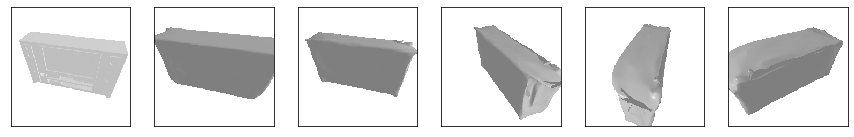

data/pytorch3d_03211117_gt_pose/batch_1_of_1/db13ba7f1da5dace4ad2635b7d12d09e.obj
Metrics before refinement -- {'2d_iou_input': 0.8715168833732605, '2d_iou_multi': 0.799765333533287, '3d_iou': 0.51538867, '3d_iou_norm': 0, 'chamfer_L1': 0.000988034880720079, 'chamfer_L1_norm': 0}
Metrics after refinement -- {'2d_iou_input': 0.9000848531723022, '2d_iou_multi': 0.79792537043492, '3d_iou': 0.25507823, '3d_iou_norm': 0, 'chamfer_L1': 0.002281652530655265, 'chamfer_L1_norm': 0}


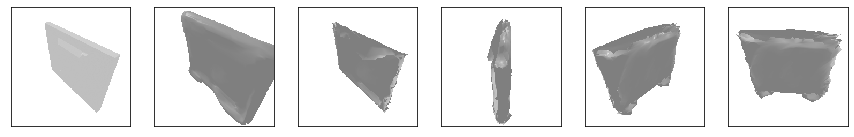

data/pytorch3d_03211117_gt_pose/batch_1_of_1/f2f41913123a7a7e4b87db09ac4cfa73.obj
Metrics before refinement -- {'2d_iou_input': 0.9166305065155029, '2d_iou_multi': 0.706859901547432, '3d_iou': 0.3627745, '3d_iou_norm': 0, 'chamfer_L1': 0.0009002346778288484, 'chamfer_L1_norm': 0}
Metrics after refinement -- {'2d_iou_input': 0.9699565768241882, '2d_iou_multi': 0.7037577318648497, '3d_iou': 0.22394833, '3d_iou_norm': 0, 'chamfer_L1': 0.001907883444800973, 'chamfer_L1_norm': 0}


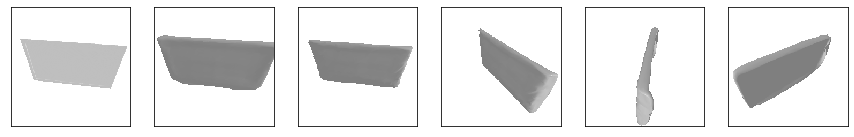

data/pytorch3d_03211117_gt_pose/batch_1_of_1/f9eb6e187d20f5908b83086412477462.obj
Metrics before refinement -- {'2d_iou_input': 0.8032233715057373, '2d_iou_multi': 0.8066823917130629, '3d_iou': 0.0, '3d_iou_norm': 0, 'chamfer_L1': 0.0009043820900842547, 'chamfer_L1_norm': 0}
Metrics after refinement -- {'2d_iou_input': 0.9583670496940613, '2d_iou_multi': 0.8034031180044016, '3d_iou': 0.0, '3d_iou_norm': 0, 'chamfer_L1': 0.0009665133547969162, 'chamfer_L1_norm': 0}


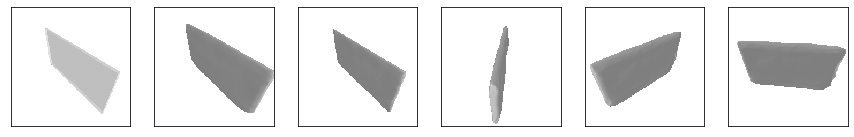

data/pytorch3d_03211117_gt_pose/batch_1_of_1/dae83168187a9ef8628fbfd12f0feda1.obj
Metrics before refinement -- {'2d_iou_input': 0.7370703816413879, '2d_iou_multi': 0.6983284863332907, '3d_iou': 0.015779093, '3d_iou_norm': 0, 'chamfer_L1': 0.005281453020870686, 'chamfer_L1_norm': 0}
Metrics after refinement -- {'2d_iou_input': 0.7489554286003113, '2d_iou_multi': 0.7430652926365534, '3d_iou': 0.33753675, '3d_iou_norm': 0, 'chamfer_L1': 0.0011392091400921345, 'chamfer_L1_norm': 0}


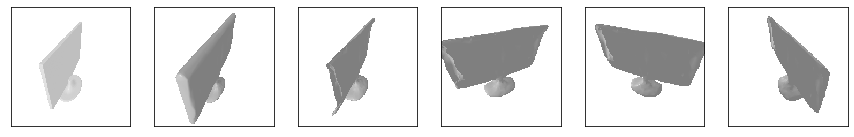

data/pytorch3d_03211117_gt_pose/batch_1_of_1/fa7324388797a2b41143ab0877fec7c3.obj
Metrics before refinement -- {'2d_iou_input': 0.8125768303871155, '2d_iou_multi': 0.7919573585192362, '3d_iou': 0.5165454, '3d_iou_norm': 0, 'chamfer_L1': 0.001131306285969913, 'chamfer_L1_norm': 0}
Metrics after refinement -- {'2d_iou_input': 0.8210673332214355, '2d_iou_multi': 0.8191440477967262, '3d_iou': 0.39912707, '3d_iou_norm': 0, 'chamfer_L1': 0.001838993513956666, 'chamfer_L1_norm': 0}


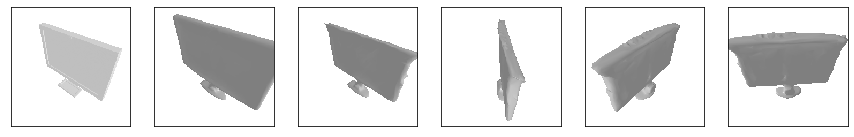

data/pytorch3d_03211117_gt_pose/batch_1_of_1/dbc61cbed5f7f2b33c1abb78f1519c49.obj
Metrics before refinement -- {'2d_iou_input': 0.7076061964035034, '2d_iou_multi': 0.6198979156712691, '3d_iou': 0.22385475, '3d_iou_norm': 0, 'chamfer_L1': 0.008848663419485092, 'chamfer_L1_norm': 0}
Metrics after refinement -- {'2d_iou_input': 0.7756995558738708, '2d_iou_multi': 0.6992325074970722, '3d_iou': 0.22149296, '3d_iou_norm': 0, 'chamfer_L1': 0.010662876069545746, 'chamfer_L1_norm': 0}


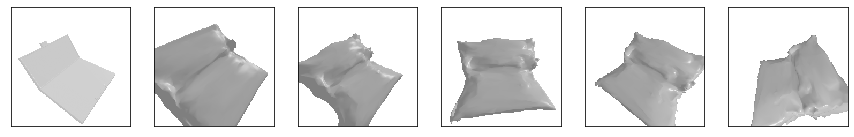

data/pytorch3d_03211117_gt_pose/batch_1_of_1/d89d1059b23e8c60edd8d267b4d8ab38.obj
Metrics before refinement -- {'2d_iou_input': 0.8865828514099121, '2d_iou_multi': 0.7724735798935095, '3d_iou': 0.35418972, '3d_iou_norm': 0, 'chamfer_L1': 0.0011736316373571754, 'chamfer_L1_norm': 0}
Metrics after refinement -- {'2d_iou_input': 0.8347752690315247, '2d_iou_multi': 0.7142076591650645, '3d_iou': 0.020607375, '3d_iou_norm': 0, 'chamfer_L1': 0.007202077656984329, 'chamfer_L1_norm': 0}


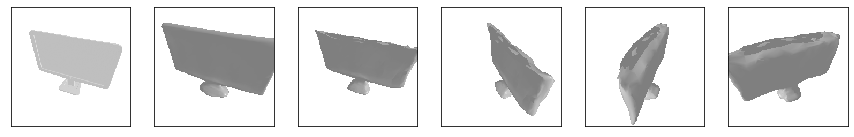

data/pytorch3d_03211117_gt_pose/batch_1_of_1/dd8cebcb4d0564059352b002a7d38daa.obj
Metrics before refinement -- {'2d_iou_input': 0.746056079864502, '2d_iou_multi': 0.7393637225031853, '3d_iou': 0.5624472, '3d_iou_norm': 0, 'chamfer_L1': 0.014558665454387665, 'chamfer_L1_norm': 0}
Metrics after refinement -- {'2d_iou_input': 0.8769294619560242, '2d_iou_multi': 0.8336402823527654, '3d_iou': 0.2525793, '3d_iou_norm': 0, 'chamfer_L1': 0.03741290792822838, 'chamfer_L1_norm': 0}


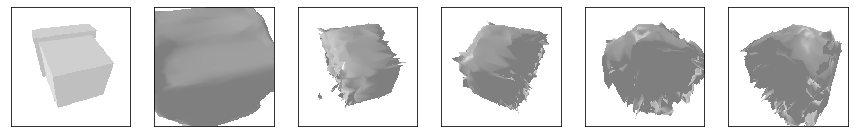

data/pytorch3d_03211117_gt_pose/batch_1_of_1/dac5376988db376b7700ed9200d31a49.obj
Metrics before refinement -- {'2d_iou_input': 0.6843938827514648, '2d_iou_multi': 0.6828163228929043, '3d_iou': 0.36095104, '3d_iou_norm': 0, 'chamfer_L1': 0.011887287721037865, 'chamfer_L1_norm': 0}
Metrics after refinement -- {'2d_iou_input': 0.8134300708770752, '2d_iou_multi': 0.6773144217828909, '3d_iou': 0.3747428, '3d_iou_norm': 0, 'chamfer_L1': 0.0077629247680306435, 'chamfer_L1_norm': 0}


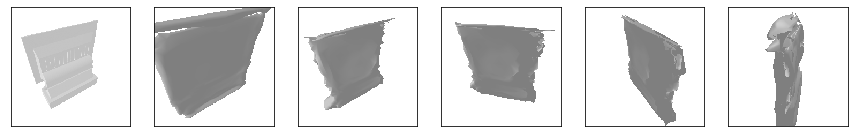

In [13]:
# show postprocessed meshes at predicted angle
instances = random.sample([str(path).split('/')[-1].replace('.obj',"") for path in list(Path(refined_models_dir).rglob('*.obj'))], 10)

m = ["2d_iou_input", "2d_iou_multi", "3d_iou","chamfer_L1"]
show_meshes(input_dir_img, input_dir_mesh, refined_models_dir, gt_shapes_dict, device, only_show_instances=instances, metrics_to_eval=m)

In [ ]:
# show training loss info
# getting paths of all loss info pickled files
input_dir_mesh = cfg['dataset']['input_dir_mesh']
output_dir = "{}_{}".format(input_dir_mesh, exp_name)
cached_loss_info_paths = list(Path(output_dir).rglob('loss_info.p'))

for path in cached_loss_info_paths:
    dataset_loss_info = pickle.load(open(path, "rb"))
    for instance_name in dataset_loss_info:
        loss_info = dataset_loss_info[instance_name]
        loss_info.plot.line(x='iteration', y='total_loss', title="{}".format(instance_name))
        #loss_info.plot.line(x='iteration', y='sil_loss')
        #loss_info.plot.line(x='iteration', y='img_sym_loss')
        #loss_info.plot.line(x='iteration', y='vertex_sym_loss')
        #loss_info.plot.line(x='iteration', y='l2_loss')
        #loss_info.plot.line(x='iteration', y='lap_smoothness_loss')
        #loss_info.plot.line(x='iteration', y='normal_consistency_loss')
        #loss_info.plot.line(x='iteration', y='semantic_dis_loss')